# **Identificação da doença de Parkinson através de desenhos espirais e senoides**

**Grupo**
* Amanda Valukas Breviglieri Joioso
* Pedro Augusto Martins Gagini
* Pedro Henrique Salmaze


# Introdução

Este notebook tem como objetivo aplicar algoritmo de **redes neurais convolucionais** para a tarefa de **classificação de imagens** de desenhos espirais e senoides, com foco na **identificação da doença de Parkinson**. Esta abordagem será contrastada com outra versão do projeto baseada em **métodos de aprendizado de máquina tradicionais**. A base de dados utilizada pode ser obtida em https://www.kaggle.com/datasets/cornelioac/parkinson-yolo-dataset


# Metodologia

* Utilizou-se o modelo **YOLOv11n-cls** para classificação de imagens, adaptando um dataset originalmente formatado para detecção.
* As imagens foram reorganizadas em pastas por rótulo, seguindo o formato da **Ultralytics**.
* O treinamento foi feito com validação cruzada estratificada (**5 folds**), por **64 épocas**, com **batch size 16** e imagens de **512x512 pixels**.
* Aplicaram-se técnicas de aumento de dados como **mosaic** e **copy-paste**.
* As principais métricas avaliadas foram: **acurácia**, **precisão**, **recall** e **F1-score (macro, micro e ponderada)**.
* O treinamento total levou cerca de **30 minutos** em um notebook com i5 de 13ª geração e GPU RTX 3050 Mobile.



# Principais Resultados

* O modelo **YOLO11n-cls** apresentou uma acurácia média de 0.882 entre os folds,
com o melhor fold chegando a 0.929, enquanto o máximo registrado por um
algoritmo clássico foi de 0.827.

* Nas outras métricas, o modelo também desempenhou muito bem, com uma
média de **0.6 pontos a mais** que os modelos clássicos.

* Tudo isso com um tempo baixo de treinamento, cerca de **30 minutos**, em um
hardware relativamente simples, considerando o padrão moderno para
treinamento de modelos de IA.

Com esses resultados, percebemos que, com o pipeline de classificação automática baseado em **YOLO**, superamos os métodos clássicos baseados em features.

# **Instalações e imports**

In [ ]:
#%pip uninstall torch torchvision torchaudio
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import shutil
import random
import json
import matplotlib.pyplot as plt
import kagglehub
import matplotlib.image as mpimg
import matplotlib.patches as patches
from sklearn.model_selection import KFold, train_test_split
from pathlib import Path
import yaml
import torch
import os
from ultralytics import YOLO

In [ ]:
# Ver estado da GPU
print(os.environ.get('CUDA_VISIBLE_DEVICES'))  # Should be None
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

None
True
1
NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [ ]:
# Download latest version
path = kagglehub.dataset_download("cornelioac/parkinson-yolo-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\osval\.cache\kagglehub\datasets\cornelioac\parkinson-yolo-dataset\versions\4


In [ ]:
# Listar todos os arquivos e pastas no caminho do dataset
conteudo_da_pasta = os.listdir(path)

# Imprimir o conteúdo
for item in conteudo_da_pasta:
  print(item)

YOLODatasetFull


In [ ]:
# Caminho para a pasta 'YOLODatasetFull'
pasta_dataset = os.path.join(path, 'YOLODatasetFull')

# Listar o conteúdo da pasta
conteudo_da_pasta = os.listdir(pasta_dataset)

# Imprimir o conteúdo
for item in conteudo_da_pasta:
  print(item)

dataset.yaml
images
labels


# **Inicialização**

In [ ]:
# Define the working directory
working_dir = '/kaggle/working/'

# Create 'all_images' and 'all_labels' in the working directory
all_images_dir = os.path.join(working_dir, 'all_images')
all_labels_dir = os.path.join(working_dir, 'all_labels')

os.makedirs(all_images_dir, exist_ok=True)
os.makedirs(all_labels_dir, exist_ok=True)

# Caminho para a pasta 'YOLODatasetFull'
pasta_dataset = os.path.join(path, 'YOLODatasetFull')

# Caminho para as pastas 'images' e 'labels'
pasta_imagens = os.path.join(pasta_dataset, 'images')
pasta_labels = os.path.join(pasta_dataset, 'labels')

# Concatenate images e labels
for pasta in ['train', 'val']:
    pasta_origem_imagens = os.path.join(pasta_imagens, pasta)
    pasta_origem_labels = os.path.join(pasta_labels, pasta)

    # Gerar a lista ordenada de nomes de imagens
    lista_nomes_imagens = sorted(os.listdir(pasta_origem_imagens))
    lista_nomes_labels = sorted(os.listdir(pasta_origem_labels))

    # Salvar a lista em um arquivo JSON
    with open('ordem_imagens.json', 'w') as f:
        json.dump(lista_nomes_imagens, f)

    with open('ordem_labels.json', 'w') as f:
        json.dump(lista_nomes_labels, f)

    # Iterar sobre os arquivos ordenados e copiar para all_images_dir e all_labels_dir
    for nome_arquivo in lista_nomes_imagens:
        shutil.copy(os.path.join(pasta_origem_imagens, nome_arquivo), all_images_dir)

    for nome_arquivo in lista_nomes_labels:
        shutil.copy(os.path.join(pasta_origem_labels, nome_arquivo), all_labels_dir)

print("Imagens e labels concatenadas com sucesso!")

# Carregar a lista de nomes do arquivo JSON
with open('ordem_imagens.json', 'r') as f:
    lista_nomes_imagens = json.load(f)

with open('ordem_labels.json', 'r') as f:
    lista_nomes_labels = json.load(f)

# Ordenar as imagens usando a lista carregada
imagens_ordenadas = [img for img in os.listdir(all_images_dir) if img in lista_nomes_imagens]
imagens_ordenadas.sort(key=lambda x: lista_nomes_imagens.index(x))

# Ordenar os labels usando a lista carregada
labels_ordenadas = [img for img in os.listdir(all_labels_dir) if img in lista_nomes_labels]
labels_ordenadas.sort(key=lambda x: lista_nomes_labels.index(x))

# Agora você pode usar 'imagens_ordenadas' para acessar as imagens na ordem desejada
print("Imagens e labels ordenadas com base na lista salva.")

Imagens e labels concatenadas com sucesso!
Imagens e labels ordenadas com base na lista salva.


**Exemplo**

A imagem exibida é de numero: 50


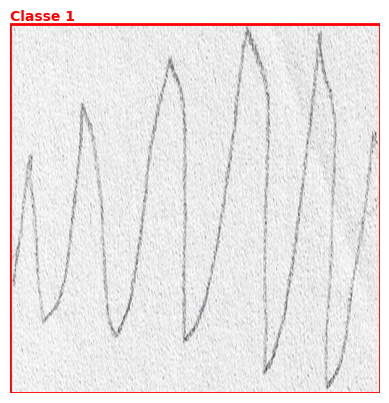

In [ ]:
numero_aleatorio = random.randint(0, len(imagens_ordenadas) - 1)
print(f"A imagem exibida é de numero: {numero_aleatorio}")

# Caminhos
caminho_imagem = os.path.join(all_images_dir, imagens_ordenadas[numero_aleatorio])
caminho_label = os.path.join(all_labels_dir, labels_ordenadas[numero_aleatorio])

# Carrega imagem
imagem = mpimg.imread(caminho_imagem)
altura, largura = imagem.shape[0], imagem.shape[1]

# Cria figura
fig, ax = plt.subplots(1)
ax.imshow(imagem)

# Lê o arquivo de labels (YOLO format)
with open(caminho_label, 'r') as f:
    linhas = f.readlines()

# Desenha cada bounding box
for linha in linhas:
    class_id, x_center, y_center, width, height = map(float, linha.strip().split())

    # Converte coordenadas normalizadas para pixels
    x_center *= largura
    y_center *= altura
    width *= largura
    height *= altura
    x_min = x_center - width / 2
    y_min = y_center - height / 2

    # Desenha o retângulo
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 5, f"Classe {int(class_id)}", color='red', fontsize=10, weight='bold')

plt.axis('off')
plt.show()

# **Organização**

In [ ]:
# Parâmetros
test_size = 0.15  # 15% para teste
random_state = 42
k = 5

# Diretórios base
folds_base = os.path.join(working_dir, "yolo_folds")
test_base = os.path.join(working_dir, "yolo_test")

# 1. Separar conjunto de teste fixo
train_val_imgs, test_imgs, train_val_labels, test_labels = train_test_split(
    imagens_ordenadas, labels_ordenadas,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

# Criar pasta para teste
test_path = Path(test_base)
(test_path / "images").mkdir(parents=True, exist_ok=True)
(test_path / "labels").mkdir(parents=True, exist_ok=True)

# Copiar arquivos do conjunto de teste
for img_name, lbl_name in zip(test_imgs, test_labels):
    shutil.copy(os.path.join(all_images_dir, img_name), test_path / "images" / img_name)
    shutil.copy(os.path.join(all_labels_dir, lbl_name), test_path / "labels" / lbl_name)

# Criar arquivo dataset.yaml para teste
test_yaml = {
    'test': str(test_path / 'images'),
    'nc': 4,
    'names': ['healthy spiral', 'healthy wave', 'parkinson spiral', 'parkinson wave']
}

with open(test_path / 'dataset.yaml', 'w') as f:
    yaml.dump(test_yaml, f)

print("Conjunto de teste criado!")
print(f"\nTotal de imagens no conjunto de teste: {len(test_imgs)}")

# 2. Criar os folds para treino/validação usando o restante dos dados
kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_imgs)):
    print(f"\nCriando fold {fold}")
    print(f" - Treino: {len(train_idx)} imagens")
    print(f" - Validação: {len(val_idx)} imagens")

    fold_path = Path(f"{folds_base}/fold{fold}")
    for split in ['train', 'val']:
        (fold_path / f"images/{split}").mkdir(parents=True, exist_ok=True)
        (fold_path / f"labels/{split}").mkdir(parents=True, exist_ok=True)

    # Copiar arquivos de treino e validação para cada fold
    for split, idxs in [('train', train_idx), ('val', val_idx)]:
        for i in idxs:
            img_name = train_val_imgs[i]
            lbl_name = train_val_labels[i]

            shutil.copy(os.path.join(all_images_dir, img_name), fold_path / f"images/{split}" / img_name)
            shutil.copy(os.path.join(all_labels_dir, lbl_name), fold_path / f"labels/{split}" / lbl_name)

    # Criar arquivo dataset.yaml para o fold atual
    data_yaml = {
        'train': str(fold_path / 'images/train'),
        'val': str(fold_path / 'images/val'),
        'nc': 4,
        'names': ['healthy spiral', 'healthy wave', 'parkinson spiral', 'parkinson wave']
    }

    with open(fold_path / 'dataset.yaml', 'w') as f:
        yaml.dump(data_yaml, f)

    print(f"Fold {fold} pronto!")

Conjunto de teste criado!

Total de imagens no conjunto de teste: 113

Criando fold 0
 - Treino: 507 imagens
 - Validação: 127 imagens
Fold 0 pronto!

Criando fold 1
 - Treino: 507 imagens
 - Validação: 127 imagens
Fold 1 pronto!

Criando fold 2
 - Treino: 507 imagens
 - Validação: 127 imagens
Fold 2 pronto!

Criando fold 3
 - Treino: 507 imagens
 - Validação: 127 imagens
Fold 3 pronto!

Criando fold 4
 - Treino: 508 imagens
 - Validação: 126 imagens
Fold 4 pronto!


In [ ]:
# Caminho base onde os folds estão salvos
base_folds_path = Path('/kaggle/working/yolo_folds')

# Caminho do conjunto de teste
test_path = Path('/kaggle/working/yolo_test/dataset.yaml')

# Imprime o conteúdo do dataset.yaml do conjunto de teste
print(f"\nConteúdo do conjunto de teste dataset.yaml:")
with open(test_path, 'r') as f:
    print(f.read())

# Itera por todas as pastas fold*/dataset.yaml e imprime o conteúdo
for fold_yaml_path in sorted(base_folds_path.glob('fold*/dataset.yaml')):
    print(f"\nConteúdo de {fold_yaml_path.parent.name}/dataset.yaml:")
    with open(fold_yaml_path, 'r') as f:
        print(f.read())


Conteúdo do conjunto de teste dataset.yaml:
names:
- healthy spiral
- healthy wave
- parkinson spiral
- parkinson wave
nc: 4
test: \kaggle\working\yolo_test\images


Conteúdo de fold0/dataset.yaml:
names:
- healthy spiral
- healthy wave
- parkinson spiral
- parkinson wave
nc: 4
train: \kaggle\working\yolo_folds\fold0\images\train
val: \kaggle\working\yolo_folds\fold0\images\val


Conteúdo de fold1/dataset.yaml:
names:
- healthy spiral
- healthy wave
- parkinson spiral
- parkinson wave
nc: 4
train: \kaggle\working\yolo_folds\fold1\images\train
val: \kaggle\working\yolo_folds\fold1\images\val


Conteúdo de fold2/dataset.yaml:
names:
- healthy spiral
- healthy wave
- parkinson spiral
- parkinson wave
nc: 4
train: \kaggle\working\yolo_folds\fold2\images\train
val: \kaggle\working\yolo_folds\fold2\images\val


Conteúdo de fold3/dataset.yaml:
names:
- healthy spiral
- healthy wave
- parkinson spiral
- parkinson wave
nc: 4
train: \kaggle\working\yolo_folds\fold3\images\train
val: \kaggle\wor

# **Formatação dos dados**
O dataset está formatado para a YOLO de detecção, mas no nosso caso a YOLO de classificação é a mais recomendada.

In [ ]:
# pasta yolo folds: base_folds_path

for directory in os.listdir(base_folds_path):

    pastas = ['train', 'val']
    subpastas = ['0', '1', '2', '3']
    basedir = os.path.join(base_folds_path, directory)

    for pasta in pastas:
        newdir = os.path.join(basedir, pasta)
        for sub in subpastas:
            caminho = os.path.join(newdir, sub)
            print(f"Criando diretório: {caminho}")
            os.makedirs(caminho, exist_ok=True)

    images_dir = os.path.join(basedir, "images\\train")
    labels_dir = os.path.join(basedir, "labels\\train")

    for png in sorted(os.listdir(images_dir)):
        img_path = os.path.join(images_dir, png)
        # Troca a extensão para .txt
        label_name = os.path.splitext(png)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_name)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                primeira_linha = f.readline().strip()
                if primeira_linha:
                    primeiro_numero = primeira_linha.split()[0]
                else:
                    primeiro_numero = 'Arquivo vazio'
        else:
            primeiro_numero = 'Arquivo .txt não encontrado'
        print(f"Imagem: {img_path} - Primeiro número do .txt: {primeiro_numero}")

        path_destino = os.path.join(basedir, f"train\\{primeiro_numero}")
        print(f"Mover: {img_path} - Para: {path_destino}")
        shutil.move(img_path, path_destino)

    images_dir = os.path.join(basedir, "images\\val")
    labels_dir = os.path.join(basedir, "labels\\val")

    for png in sorted(os.listdir(images_dir)):
        img_path = os.path.join(images_dir, png)
        # Troca a extensão para .txt
        label_name = os.path.splitext(png)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_name)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                primeira_linha = f.readline().strip()
                if primeira_linha:
                    primeiro_numero = primeira_linha.split()[0]
                else:
                    primeiro_numero = 'Arquivo vazio'
        else:
            primeiro_numero = 'Arquivo .txt não encontrado'
        print(f"Imagem: {img_path} - Primeiro número do .txt: {primeiro_numero}")

        path_destino = os.path.join(basedir, f"val\\{primeiro_numero}")
        print(f"Mover: {img_path} - Para: {path_destino}")
        shutil.move(img_path, path_destino)


**Descrição de cada Parâmetro**




| Parâmetro    | Tipo    | Exemplo       | Descrição                                                                |
| ------------ | ------- | ------------- | ------------------------------------------------------------------------ |
| `data`       | `str`   | `'data.yaml'` | Caminho para o arquivo `.yaml` que define o dataset (classes, caminhos). |
| `epochs`     | `int`   | `64`         | Número de vezes que o modelo verá todo o conjunto de treino.             |
| `batch`      | `int`   | `16`          | Quantidade de imagens processadas por vez (por lote).                    |
| `imgsz`      | `int`   | `512`         | Tamanho das imagens (serão redimensionadas para isso).                   |
| `mosaic`     | `float` | `1.0`         | Ativa Mosaic augmentation (combina 4 imagens em uma).                    |
| `mixup`      | `float` | `0.0`         | Ativa MixUp (mistura duas imagens e rótulos).                            |
| `copy_paste` | `float` | `0.1`         | Ativa Copy-Paste augmentation (cola objetos de outras imagens).          |
| `device`     | `str`   | `'cuda'`      | Define se vai usar GPU (`'cuda'`) ou CPU (`'cpu'`).                      |


In [ ]:
#USO DA YOLO
import numpy as np

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()

class_names = []
n_folds = 5

for fold in range(n_folds):
    print(f"\nTreinando Fold {fold}")

    # Limpa cache da GPU
    torch.cuda.empty_cache()

    # Carrega modelo YOLOv12 (verifique se yolov12n.pt está no seu diretório)
    model = YOLO('yolo11n-cls.pt')

    # Caminho para o dataset.yaml do fold atual
    data_yaml_path = f"{folds_base}/fold{fold}/dataset.yaml"

    with open(data_yaml_path, 'r') as f:
       data_yaml = yaml.safe_load(f)
    class_names = data_yaml.get('names', [])

    data_path = f"{folds_base}/fold{fold}"

    # Treinamento
    results = model.train(
        data=data_path,
        epochs=64,
        batch=16,
        imgsz=512,
        mosaic=1.0,
        mixup=0.0,
        copy_paste=0.1,
        device='cuda'
    )

    torch.cuda.empty_cache()
    print("# Validação")
    metrics = model.val()

    acuracia = metrics.top1
    print(f"Acurácia: {acuracia:.3f}")

    # Matriz de confusão (geralmente em metrics.confusion_matrix.matrix)
    cm = metrics.confusion_matrix.matrix

    print(cm)

    # Salvar todos os resultados
    np.savez(
        f"metricas_fold{fold}.npz",
        acuracia=acuracia,
        matriz_confusao=cm,
        # salvar precison, f1 e recall
    )

    print(f"Fold {fold} salvo com sucesso.\n")


# **Avaliação**

| Nome                 | O que é                                                                              | Como é calculado                                          |
| -------------------- | ------------------------------------------------------------------------------------ | --------------------------------------------------------- |
| `fold`               | Número do fold atual na validação cruzada.                                           | Número inteiro (0, 1, 2...)                               |
| `acuracia`           | Proporção de previsões corretas entre todas as amostras.                             | `(acertos / total)`                                       |
| `macro_precision`    | Média da **precisão** por classe, **sem considerar o tamanho das classes**.          | Média da precisão de cada classe                          |
| `macro_recall`       | Média do **recall** por classe, igualmente ponderado.                                | Média do recall de cada classe                            |
| `macro_f1`           | Média do **F1-score** por classe (harmônica entre precisão e recall), não ponderada. | Média do F1 de cada classe                                |
| `weighted_precision` | Média ponderada da **precisão**, de acordo com o número de amostras por classe.      | Precisão ponderada pelo suporte (quantidade de exemplos)  |
| `weighted_recall`    | Média ponderada do **recall**, considerando classes desbalanceadas.                  | Recall ponderado pelo suporte                             |
| `weighted_f1`        | Média ponderada do **F1-score**, mais estável com classes desbalanceadas.            | F1-score ponderado pelo suporte                           |
| `micro_precision`    | Calcula TP, FP e FN globalmente antes de calcular a **precisão**.                    | Mais preciso quando há muitas classes ou desbalanceamento |
| `micro_recall`       | Calcula TP, FN globalmente antes de calcular o **recall**.                           | Útil para multi-classe ou datasets grandes                |
| `micro_f1`           | F1-score global, combinando todos os exemplos antes de calcular.                     | Melhor métrica quando há muito desbalanceamento           |


In [ ]:
import numpy as np

def get_confusion_elements(cm, k):
    TP = cm[k, k]
    FP = cm[:, k].sum() - TP
    FN = cm[k, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    return TP, FP, FN, TN

fold_metrics = []

for fold in range(5):
    data = np.load(f"metricas_fold{fold}.npz")
    cm = data['matriz_confusao']
    acur = data['acuracia']
    print(f"\nFold {fold} - Matriz de confusão:")
    print(cm)

    num_classes = cm.shape[0]
    precisions, recalls, f1s, supports = [], [], [], []

    for k in range(num_classes):
        TP, FP, FN, TN = get_confusion_elements(cm, k)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        support = cm[k, :].sum()
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        supports.append(support)

    # Macro médias
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1s)

    # Weighted médias
    total_support = np.sum(supports)
    weighted_precision = np.sum(np.array(precisions) * supports) / total_support
    weighted_recall = np.sum(np.array(recalls) * supports) / total_support
    weighted_f1 = np.sum(np.array(f1s) * supports) / total_support

    # Micro médias
    TP_total = sum(get_confusion_elements(cm, k)[0] for k in range(num_classes))
    FP_total = sum(get_confusion_elements(cm, k)[1] for k in range(num_classes))
    FN_total = sum(get_confusion_elements(cm, k)[2] for k in range(num_classes))
    micro_precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
    micro_recall = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    # Armazene os resultados do fold
    fold_metrics.append({
        'fold': fold,
        'acuracia': acur,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1': weighted_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1
    })

# Exemplo de como acessar os resultados:
for m in fold_metrics:
    print(f"\nFold {m['fold']}:")
    print(f"  Acuracia: {m['acuracia']:.3f}")
    print(f"  Macro Precision: {m['macro_precision']:.3f}")
    print(f"  Weighted Precision: {m['weighted_precision']:.3f}")
    print(f"  Micro Precision: {m['micro_precision']:.3f}")
    print(f"  Macro Recall: {m['macro_recall']:.3f}")
    print(f"  Weighted Recall: {m['weighted_recall']:.3f}")
    print(f"  Micro Recall: {m['micro_recall']:.3f}")
    print(f"  Macro F1: {m['macro_f1']:.3f}")
    print(f"  Weighted F1: {m['weighted_f1']:.3f}")
    print(f"  Micro F1: {m['micro_f1']:.3f}")

metricas = ['acuracia', 'macro_precision', 'weighted_precision', 'micro_precision',
            'macro_recall', 'weighted_recall', 'micro_recall',
            'macro_f1', 'weighted_f1', 'micro_f1']

for metrica in metricas:
    valores = [m[metrica] for m in fold_metrics]
    media = np.mean(valores)
    desvio = np.std(valores)
    print(f"{metrica}: média = {media:.3f}, desvio = {desvio:.3f}")


Fold 0 - Matriz de confusão:
[[16.  0.  3.  0.]
 [ 0. 28.  0.  4.]
 [ 8.  0. 46.  0.]
 [ 0.  2.  0. 20.]]

Fold 1 - Matriz de confusão:
[[13.  0.  0.  0.]
 [ 0. 33.  0.  6.]
 [ 5.  0. 50.  0.]
 [ 0.  2.  0. 18.]]

Fold 2 - Matriz de confusão:
[[14.  0.  9.  0.]
 [ 0. 39.  0.  3.]
 [ 4.  0. 34.  0.]
 [ 0.  3.  0. 21.]]

Fold 3 - Matriz de confusão:
[[ 8.  0.  2.  0.]
 [ 0. 35.  0.  2.]
 [ 4.  0. 44.  0.]
 [ 0.  1.  0. 31.]]

Fold 4 - Matriz de confusão:
[[18.  0.  6.  0.]
 [ 0. 22.  0.  3.]
 [ 3.  0. 46.  0.]
 [ 0.  3.  0. 25.]]

Fold 0:
  Acuracia: 0.866
  Macro Precision: 0.843
  Weighted Precision: 0.878
  Micro Precision: 0.866
  Macro Recall: 0.870
  Weighted Recall: 0.866
  Micro Recall: 0.866
  Macro F1: 0.853
  Weighted F1: 0.869
  Micro F1: 0.866

Fold 1:
  Acuracia: 0.898
  Macro Precision: 0.854
  Weighted Precision: 0.915
  Micro Precision: 0.898
  Macro Recall: 0.914
  Weighted Recall: 0.898
  Micro Recall: 0.898
  Macro F1: 0.875
  Weighted F1: 0.901
  Micro F1: 0.898

Fo